With reference to Dr. Stefan Kremer Jupyter Notebooks - CIS*4780 Assignment 1 and 07 - ConvNets

# Table of Contents
## OCR-A Recognition Network

<a href='#img_preproc'>Image and Data Preprocessing</a>

<a href='#network'>Neural Network Initialization and Training (Single-Layer Perceptron)</a>

## Experiments
<a href='#exp'>Image Classification Tests</a>

## Appendix
<a href='#diagnostic'>Diagnostic Tools</a>

# OCR-A Recognition Network

In [1]:
# Start with the necessary imports
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from PIL import ImageOps

<a id="img_preproc"></a>

## Image and Data Preprocessing

The purpose of this neural network is to recognize and classify OCR-A font glyphs. The glyphs to be used are the sets of OCR-A digit, unaccented uppercase, and unaccented lowercase glyphs, shown below. 

<img src="img/120px-OCR-A_char_digits.png", align=center/>
<img src="img/350px-OCR-A_char_unaccented_capital_letters.png", align=center/>
<img src="img/350px-OCR-A_char_unaccented_small_letters.png", align=center/>

The glyphs were hand-extracted from a different set of images containing the glyphs and were each set into a 48x48 PNG image, available in the OCR-A-Glyphs directory. We will start with reading in our original OCR-A glyph data from that directory.

<b>NOTE:</b> The OCR-A-Glyphs directory is assumed to be at the same directory level as this notebook, and should have been delivered with this notebook.

In [2]:
# This code simply lays out an array of Images, each converted to grayscale and inverted
glyphs = []
for glyph in os.listdir("./OCR-A-Glyphs"):
    img = Image.open("OCR-A-Glyphs/" + glyph)
    imgGrayInv = ImageOps.invert(img.convert(mode="L"))
    glyphs.append(imgGrayInv)

To simplify the network, the images that are read in are converted to grayscale minimize the number of parameters to train. Font recognition does not distinguish colour data, so this is a reasonable choice. Additionally, the images are inverted so that the background is black (0), so that when rotations are made, the image is not left with rotation leftovers from the edges if the rotation is not 0/90/180/270/360.

One-hot encoding is used to identify each glyph and will function as the label. The order in which the glyphs are read are irrelevant and will be paired with the one-hot encoding that matches their index in the original glyph data. There are 62 glyphs in total, so calls to onehot (based off of onehot() from Assignment 1.ipynb) will have  n = 62 (2 x 26 letters + 10 digits).

In [3]:
def onehot(i, n):
    return [ int(i==j) for j in range(0,n) ];

### Input-Output Pairs
To form the input-output pairs that the network will observe, the input Images need to be modified to be arrays of their pixel data.

Two functions will be defined to supply two different sets of training data: a completely normal data set, and a set with images that are <b>rotated, shifted, and noisy</b> to expand the data set. The parameter bounds were chosen by determining the ranges which a typical test image will be presented as.

* <b>Rotation:</b> 45 degrees clockwise and counterclockwise
    * Without turning the actual image, this range of rotation can still be reasonable interpreted by both human and machine
* <b>Shift:</b> +/- 10 pixel shift horizontally and vertically
    * This range of shifting moderately explores the available space of 48x48, though some glyphs may have parts exit the image
* <b>Noise:</b> 1% noise probability per pixel
    * With a reasonably supplied image, noise likely does not amount to more than 10% MAX, 1% is chosen for convenience.

In [4]:
import random

MAX_ROT = 45
MAX_SHIFT = 10
NOISE = 0.01

def transform_glyph(glyph):
    # Built in modulus operation makes this work
    rot = random.randint(-MAX_ROT, MAX_ROT)
    rotGlyph = glyph.rotate(360 + rot)
    
    # This shift is actually an affine transformation with carefully set data transformations so that it becomes a shift only
    shiftHor = random.randint(-MAX_SHIFT, MAX_SHIFT)
    shiftVer = random.randint(-MAX_SHIFT, MAX_SHIFT)
    shiftGlyph = rotGlyph.transform(rotGlyph.size, Image.AFFINE, (1, 0, shiftHor, 0, 1, shiftVer))
    
    pixels = shiftGlyph.load()
    for i in range(shiftGlyph.size[0]):
        for j in range(shiftGlyph.size[1]):
            randNum = random.random()
            if randNum < NOISE:
                pixels[i,j] = 255 - pixels[i,j]    # 255 - pixel value 'flips' value across midway point
        
    return shiftGlyph

In [5]:
DTYPE = "float32"

# This ultimately is here for bookkeeping, is not used anywhere in this notebook
def normal_data():
    # This is a normal Image -> pixel data conversion
    imgPixelGlyphs = []
    for glyph in glyphs:
        imgPixel = np.array([ pixel for pixel in iter(glyph.getdata()) ])
        imgPixelGlyphs.append(imgPixel)
    
    input_array = np.array([ imgArray for imgArray in imgPixelGlyphs ]);
    output_array = np.array([ onehot(digit,62) for digit in range(0,62) ]);
    return input_array.astype(DTYPE), output_array.astype(DTYPE);
       
# The parameter for this function is to denote how many extra image data are to be added with 'normal' data
def expanded_data(nAddData):
    # This is a normal Image -> pixel data conversion + nAddData additional Image 'mixes'
    imgPixelGlyphs = []
    for glyph in glyphs:
        imgPixel = np.array([ pixel for pixel in iter(glyph.getdata()) ])
        imgPixelGlyphs.append(imgPixel)
        
        for newImage in range(0,nAddData):
            transformGlyph = transform_glyph(glyph)
            imgPixelTrans = np.array([ pixel for pixel in iter(transformGlyph.getdata()) ])
            imgPixelGlyphs.append(imgPixelTrans)
    
    input_array = np.array([ imgArray for imgArray in imgPixelGlyphs ]);
    
    output_array = np.array([ onehot(digit,62) for digit in range(0,62) for newImage in range(0,nAddData + 1) ]);
    return input_array.astype(DTYPE), output_array.astype(DTYPE);

In [6]:
# Print the output to check if we have the correct number of images and one-hot encodings
# (for a given number of additional images)
n_input, n_output = normal_data()
print n_input, n_output, n_input.shape, n_output.shape

# 5 will be the chosen number of additional images, bringing the total amount of images to 372
ex_input, ex_output = expanded_data(5)
print ex_input, ex_output, ex_input.shape, ex_output.shape

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]] [[ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  1.  0.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]] (62, 2304) (62, 62)
[[   0.    0.    0. ...,    0.    0.    0.]
 [   0.    0.    0. ...,    0.    0.    0.]
 [   0.    0.    0. ...,    0.    0.    0.]
 ..., 
 [   0.    0.    0. ...,    0.    0.    0.]
 [   0.    0.    0. ...,    0.    0.    0.]
 [   0.    0.    0. ...,  255.    0.    0.]] [[ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]] (372, 2304) (372, 62)


We now have our data set! Now it's time to construct our neural network.

<a id="network"></a>

## Neural Network Initialization and Training (Single-Layer Perceptron)

A basic single-layer perceptron (SLP) will be constructed for this recognition task, with Assignment 1's network as the working model. Originally, a convolutional neural network was to be constructed, but there were too many major difficulties in implementation and roadblocks in understanding to complete it. A code graveyard can be found at the <a href='#diagnostic'>Appendix</a>.

The generic single-layer perceptron function construct_model() will be the network's backbone. No outstanding changes were made to the structure of the code, as it is very flexible. Here we simply *define* the network's *potential* structure, with parameters determining the final connections.

In [7]:
from numpy.random import uniform
EPS = np.finfo(np.double).eps

# derived from Assignment 1.ipynb with minor alterations
def construct_model(n_inputs, n_hidden, n_outputs, lr):
    # initialization from Glorot and Bengio 2010.
    # weights from input to hidden, random on uniform distribution
    W_hid = tf.Variable( uniform( low=-4 * np.sqrt(6.0 / (n_inputs + n_hidden)), \
                                  high=4 * np.sqrt(6.0 / (n_inputs + n_hidden)),\
                                  size=(n_inputs,n_hidden) \
                                ).astype('float32'), \
                         name='W_h' )
    
    # bias from input to hidden, zeros
    b_hid = tf.Variable( np.zeros( [n_hidden], dtype=DTYPE ), \
                         name='b_h' )

    # weights from hidden to output, random on uniform distribution
    W_out = tf.Variable( uniform( low=-4 * np.sqrt(6.0 / (n_hidden + n_outputs)),\
                                  high=4 * np.sqrt(6.0 / (n_hidden + n_outputs)),\
                                  size=(n_hidden, n_outputs) \
                                ).astype('float32'), \
                         name='W_o' )
    
    # bias from hidden to output
    b_out =  tf.Variable( tf.zeros([n_outputs]), 
                          name='b_o' )
    
    # images to be put in
    input_x = tf.placeholder(tf.float32, [None, n_inputs] )
    
    # one hot labels to match
    label_y = tf.placeholder(tf.float32, [None, n_outputs] )
    
    # calculate pre-activation and calculate activation function (sigmoid in this instance)
    h_in = tf.nn.bias_add(tf.matmul(input_x, W_hid), b_hid)
    h_out = tf.sigmoid(h_in)
    
    o_in = tf.nn.bias_add(tf.matmul(h_out, W_out), b_out)
    y_pred = tf.sigmoid(o_in)
    
    # loss function to minimize
    cost = -tf.reduce_mean( label_y * tf.log(y_pred + EPS) + (1 - label_y) * tf.log(1 - y_pred + EPS) )

    # gradient descent optimization as the method to minimize
    train_op = tf.train.GradientDescentOptimizer(lr).minimize(cost)

    # compute accuracy
    # if element > 0.5 replace with 1
    bool_vec = tf.greater(y_pred, 0.5)
    correct_prediction = tf.equal(label_y, tf.cast(bool_vec, tf.float32))
    # convert all boolean to float, to calculate percentage
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    
    return input_x, label_y, accuracy, cost, train_op, y_pred

With the network possibilities defined, we can now define a specific model instance.

With a <b>48x48</b> image set and <b>62</b> different classifications, the network will undoubtedly be <b>big</b>. Convolutional neural networks will have eased this by pooling together areas of the input and calculating them all the same for each feature map. For now, we will continue with this SLP.

In [8]:
input_x, label_y, accuracy, cost, train_op, y_pred = construct_model( 2304, 30, 62, 0.1 )

We will now define a training regimen. Using our expanded data set from expanded_data(), we will train this neural network to a total of <b>7500</b> epochs, marking the progress every 500 epochs. Once training is complete, experimentations can be made.

In [9]:
def train_network(epochs):
    sess = tf.Session()   # execute the tensor flow session
    sess.run(tf.global_variables_initializer())   # initialize all the global variables

    train_costs = np.zeros(epochs, dtype='float32');
    train_accuracies = np.zeros(epochs, dtype='float32');
    
    # Train the network
    print "Epoch  Cost   Accuracy"
    for i in xrange(epochs):
        train_cost, train_accuracy, _ = sess.run([cost, accuracy, train_op], feed_dict={input_x: ex_input, label_y: ex_output})
        train_costs[i] = train_cost
        train_accuracies[i] = train_accuracy
        if i % 500 == 0:
            print "%05d  %5.3f  %5.3f" % (i,train_cost,train_accuracy);
    print "%05d  %5.3f  %5.3f" % (i,train_cost,train_accuracy);        
    
    return train_costs, train_accuracies, y_pred, sess;

In [10]:
train_costs, train_accuracies, y_pred, sess = train_network(7500)

Epoch  Cost   Accuracy
00000  1.152  0.505
00500  0.246  0.920
01000  0.149  0.969
01500  0.123  0.978
02000  0.112  0.980
02500  0.106  0.982
03000  0.102  0.982
03500  0.100  0.983
04000  0.098  0.983
04500  0.097  0.983
05000  0.096  0.983
05500  0.096  0.983
06000  0.095  0.983
06500  0.094  0.983
07000  0.094  0.984
07499  0.094  0.984


# Experiments

<a id="exp"></a>
With our network ready, it is now time to do some tests!

## Image Classification Tests

Originally, the tests were supposed to encompass comparing costs to variations in hyperparameters. With the decision to use the template model, however, the experiments will now focus solely on classification results, similar to Assignment 1.

To create this experiment, after out initial training above, we will now assess how the network will perform classfication with an entirely new set of inputs and outputs, generated from expanded_data(). Again, the expanded data set will include the 'neutral' Images along with 5 extra Images per glyph.

Let's produce a new set of data to test!

-----

The experiment will focus on how our convolutional neural network performs with various rotations, shifts and noise, given the
previous parameters it has previously observed.

* <b>Rotation:</b> 0, 30, 60 degree rotations
* <b>Shift:</b> 0, 10, 20 pixel shifts
* <b>Noise:</b> 0%, 5%, 10% noise percentage
    
We will create <b>27</b> total data sets of <b>10</b> images based on the combinations of these variations.

In [11]:
rotations = [0, 30, 60]
shifts = [0, 10, 20]
noise = [0.00, 0.05, 0.10]
exp = 0
exp_data = []        # array of 9 experiments, each with 10 images
target_data = []     # for each 9 experiments, these are the 10 one-hot targets

for rotation in rotations:
    for shift in shifts:
        for noiseLevel in noise:
            MAX_ROT = rotation
            MAX_SHIFT = shift
            NOISE = noiseLevel
            
            imgExpGlyphs = []    # within one experiment, these are the 10 images with 10 one-hot targets
            correctOneHot = []
            for imgTest in range(10):
                glyphNum = random.randint(0, 61)
                transformGlyph = transform_glyph(glyphs[glyphNum])
                imgExpTrans = np.array([ pixel for pixel in iter(transformGlyph.getdata()) ])
                imgExpGlyphs.append(imgExpTrans)
                correctOneHot.append(glyphNum)
    
            # when an experiment set is made, numpy-ise it
            exp_array = np.array([ imgExp for imgExp in imgExpGlyphs ]);
            target_array = np.array([ onehot(numGlyph,62) for numGlyph in correctOneHot ]);
            
            exp_data.append(exp_array)
            target_data.append(target_array)
            exp = exp + 1

With our data sets made, it's time to test! The test scheme will be like Assignment 1, where we will analyze if the network is able to correctly predict the glyph it is given and extract a percentage of correct answers.

In [12]:
for expNum in range(27):
    print "Experiment", expNum + 1
    correctClass = 0
    outputs = sess.run( y_pred, feed_dict={input_x: exp_data[expNum], label_y: target_data[expNum]});

    for glyphGuess in range(10):
        o = outputs[glyphGuess].tolist()
        t = target_data[expNum][glyphGuess].tolist()
        if (o.index(max(o)) == t.index(max(t))):
            correctClass = correctClass + 1
            
    print "Total Correct = ", correctClass, "Correct % = ", correctClass / 10. * 100

Experiment 1
Total Correct =  0 Correct % =  0.0
Experiment 2
Total Correct =  0 Correct % =  0.0
Experiment 3
Total Correct =  0 Correct % =  0.0
Experiment 4
Total Correct =  0 Correct % =  0.0
Experiment 5
Total Correct =  1 Correct % =  10.0
Experiment 6
Total Correct =  0 Correct % =  0.0
Experiment 7
Total Correct =  0 Correct % =  0.0
Experiment 8
Total Correct =  0 Correct % =  0.0
Experiment 9
Total Correct =  1 Correct % =  10.0
Experiment 10
Total Correct =  0 Correct % =  0.0
Experiment 11
Total Correct =  0 Correct % =  0.0
Experiment 12
Total Correct =  0 Correct % =  0.0
Experiment 13
Total Correct =  1 Correct % =  10.0
Experiment 14
Total Correct =  0 Correct % =  0.0
Experiment 15
Total Correct =  0 Correct % =  0.0
Experiment 16
Total Correct =  0 Correct % =  0.0
Experiment 17
Total Correct =  0 Correct % =  0.0
Experiment 18
Total Correct =  0 Correct % =  0.0
Experiment 19
Total Correct =  0 Correct % =  0.0
Experiment 20
Total Correct =  0 Correct % =  0.0
Experi

# Appendix

<a id="diagnostic"></a>
This section is simply a place to keep various tests to ensure that aspects of my project work as intended. This is also the resting place for my attempt at a convolutional neural network...

## Diagnostic Tools

In [13]:
# Here lies my attempt to put together a convolutional neural network using the bits and pieces from 07 - ConvNets
# Also tf-slim is not well-documented right now, something to look for when it comes

# represents a "dense" convolution in all dimensions (i.e. all strides set to 1)
#def convolve(_input, w):
#    # note that w is [filter_height, filter_width, in_channels, out_channels]
#    return tf.nn.conv2d(_input, w, strides=[1, 1, 1, 1], padding='VALID')  

# classical max pooling in a 2x2 window
#def max_pool(activation):
#    return tf.nn.max_pool(activation, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

#def softmax_cross_entropy(nn_out, y):
#    sm = tf.nn.softmax(nn_out)
#    cost = -tf.reduce_mean(y*tf.log(sm))
#    return sm, cost

# This is a new method to contain a single convolution layer within a function.
# it is useful when you need to build large number of layers with differing parameters.
#def convpool_layer(_input, filter_shape, input_shape):
#    minval = -np.sqrt(6.0 / (filter_shape[2] // 4 + filter_shape[3]))
#    maxval = np.sqrt(6.0 / (filter_shape[2] // 4 + filter_shape[3]))
#    conv_w = tf.Variable(tf.random_uniform(filter_shape, minval, maxval))
#    conv_b =  tf.Variable(tf.random_uniform([filter_shape[3]], minval, maxval))
    # Reshape input
#    _input_r = tf.reshape(_input, shape=input_shape)
    # Convolution
#    conv = convolve(_input_r, conv_w)
    # Add-bias
#    preact = tf.nn.bias_add(conv, conv_b)
    # Pass ReLu
#    activation = tf.nn.relu(preact)
    # Max-pooling
#    pool_out  = max_pool(activation)

    # Useful to create this dictionary during debugging, you are able to sess run on 
    # any parts of the model. 
#    out = {
#        'max' : maxval,
#        'conv_w' : conv_w,
#        'conv_b' : conv_b,
#        'out': pool_out
#    }
#    return out


#def FC_layer(x, input_shape):

#    fc_w = tf.Variable(tf.random_normal([input_shape[1]*input_shape[2]*input_shape[3],\
#                                         n_output], stddev=0.1))
#    fc_b = tf.Variable(tf.random_normal([n_output], stddev=0.1))
#    x = tf.reshape(x, [-1, fc_w.get_shape().as_list()[0]])
#    out = tf.add(tf.matmul(x, fc_w), fc_b)

#    return out

# HyperParameters
#learning_rate   = 0.001
#max_epochs      = 2
#batch_size      = 62
#display_step    = 1

# Network Parameters
#n_input  = 2304
#n_output = 62
#nchannels = [1, 6, 6] # For speed purposes limit

# tf Graph input
#x = tf.placeholder(tf.float32, [None, n_input])
#y = tf.placeholder(tf.float32, [None, n_output])

# let's construct our CNN architecture.

#l0_out = convpool_layer(x, filter_shape=[5,5,nchannels[0],nchannels[1]] ,input_shape=[-1,48,48,nchannels[0]])
#l1_out = convpool_layer(l0_out['out'], filter_shape=[5,5,nchannels[1],nchannels[2]] ,\
#                    input_shape=[-1,22,22,nchannels[1]])
#nn_out = FC_layer(l1_out['out'], input_shape=[-1,9,9,nchannels[2]])

#sm, cost = softmax_cross_entropy(nn_out, y)
#optm = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Find correct
#_corr = tf.equal(tf.argmax(sm,1), tf.argmax(y,1)) 
# Accuracy
#accr = tf.reduce_mean(tf.cast(_corr, tf.float32)) 

#init = tf.global_variables_initializer()
#sess = tf.Session()
#sess.run(init)
#print "Let's start Training."

#for epoch in range(max_epochs):
#    avg_cost = 0.
#    total_batch = int(372/batch_size)

    # Loop over all batches
#    for i in range(total_batch):
#        batch_xs = ex_input[i*batch_size:(i+1)*batch_size]
#        print batch_xs.shape
#        batch_ys = ex_output[i*batch_size:(i+1)*batch_size]

        # Fit training using batch data
#        sess.run(optm, feed_dict={x: batch_xs, y: batch_ys})
        # Compute average loss
        #print sess.run(l0_out['conv_w'], feed_dict={x: batch_xs, y: batch_ys})
#        avg_cost += sess.run(cost, feed_dict={x: batch_xs, y: batch_ys})/total_batch

    # Display logs per epoch step
#    if epoch % display_step == 0: 
#        print ("Epoch: %03d cost: %.9f" % (epoch, avg_cost))
#        train_acc = sess.run(accr, feed_dict={x: batch_xs, y: batch_ys})
#        print (" Training accuracy: %.3f" % (train_acc))
        

#print ("Training Finished.")

#test_acc, test_cost = sess.run([accr,cost], feed_dict={x: testimg, y: testlabel})
#print (" Test cost: %.3f" % (test_cost))
#print (" Test accuracy: %.3f" % (test_acc))

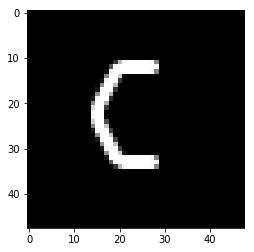

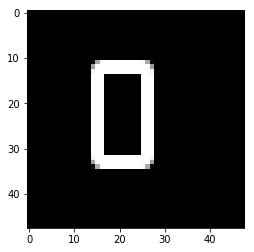

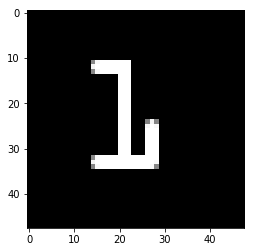

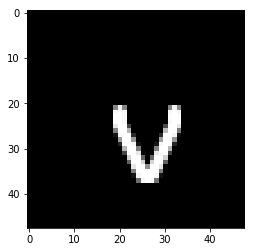

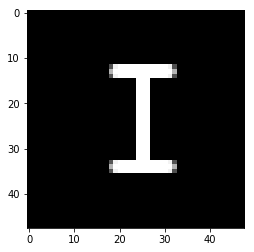

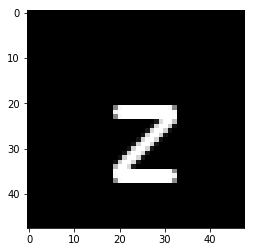

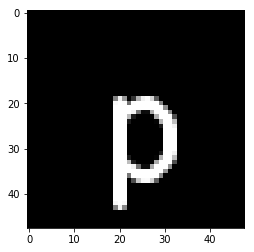

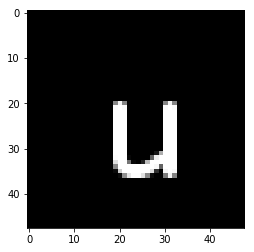

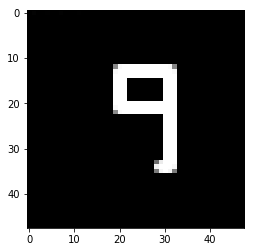

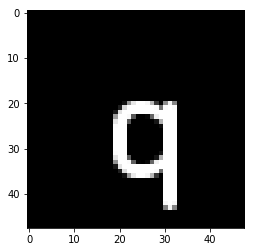

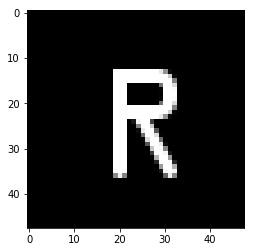

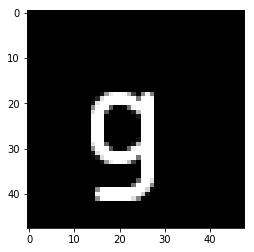

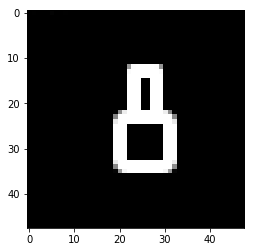

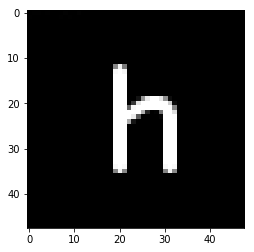

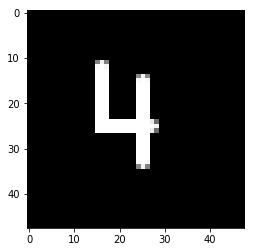

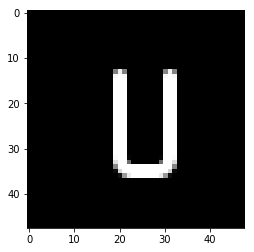

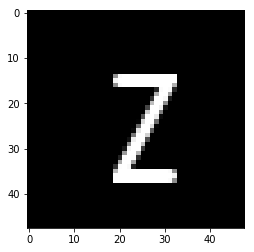

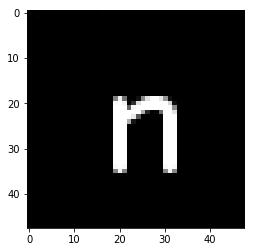

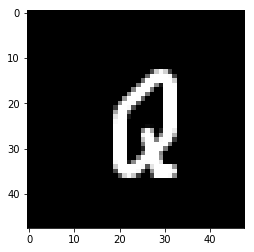

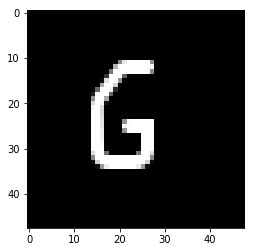

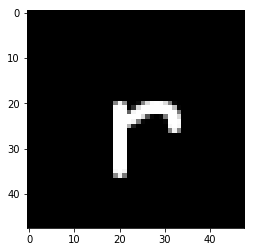

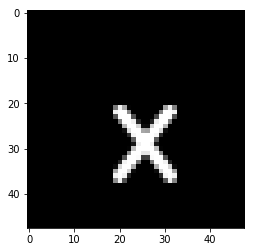

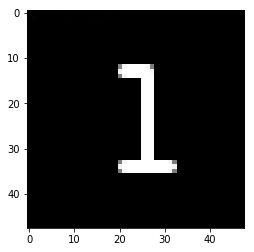

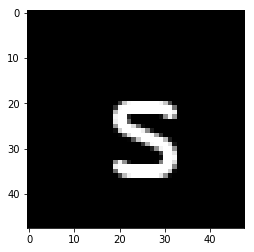

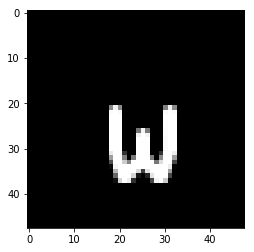

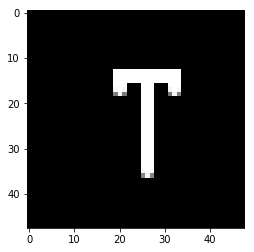

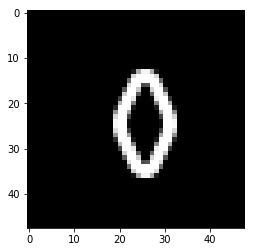

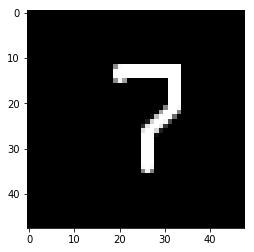

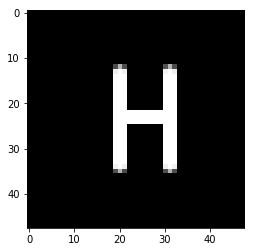

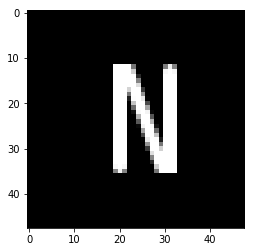

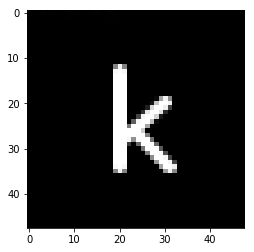

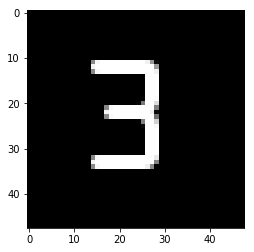

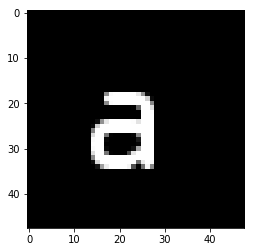

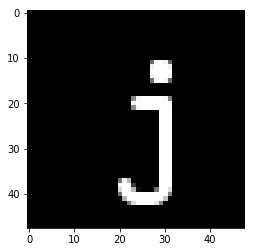

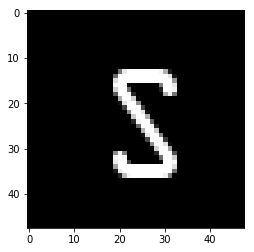

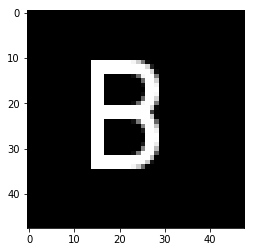

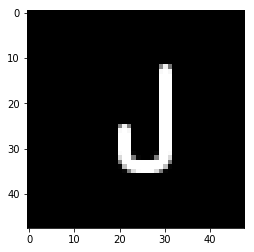

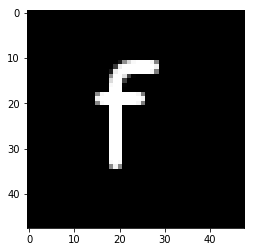

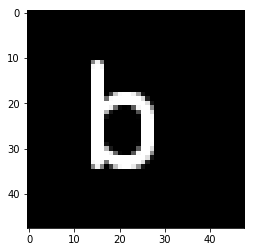

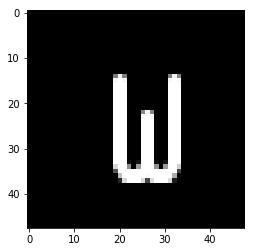

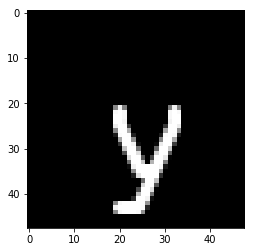

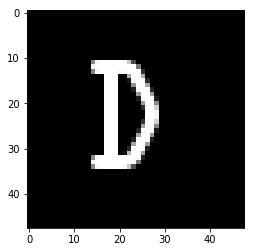

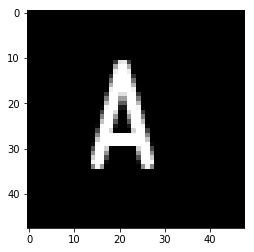

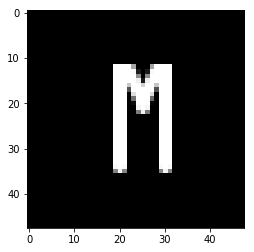

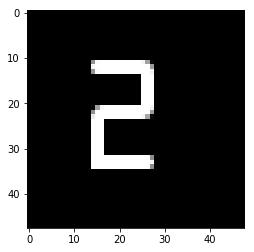

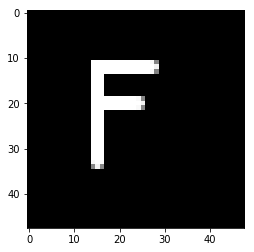

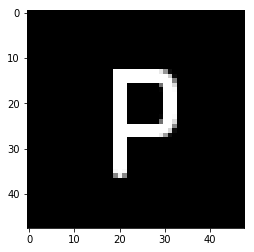

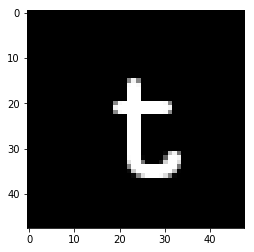

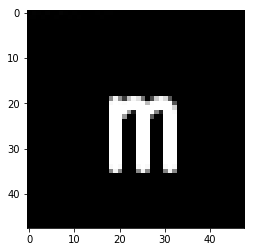

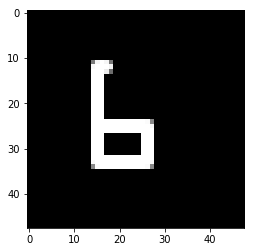

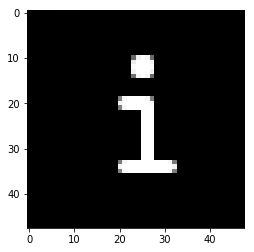

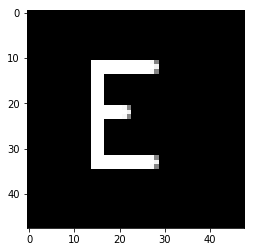

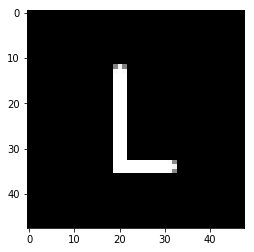

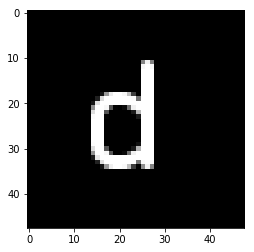

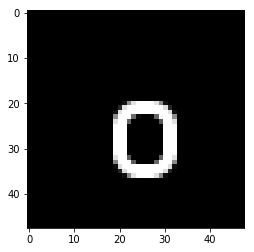

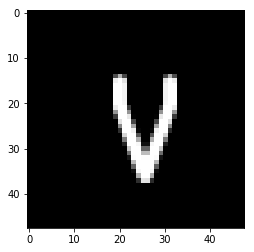

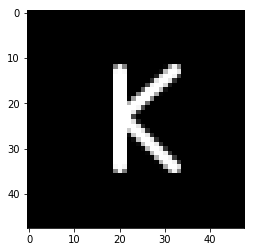

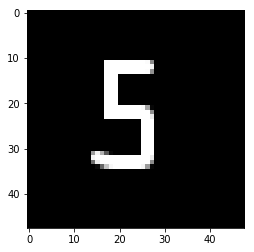

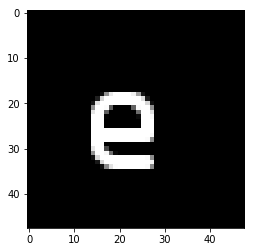

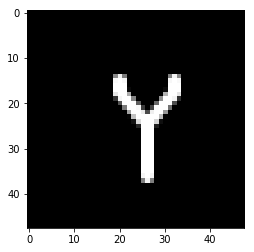

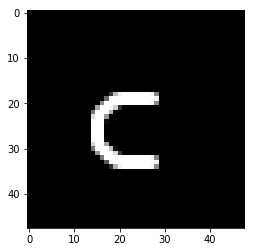

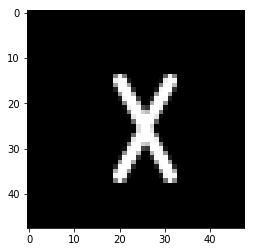

In [14]:
# See if glyphs are read in and converted correctly
for glyph in glyphs:
    imgPlot = plt.imshow(glyph, cmap="gray")
    plt.show()

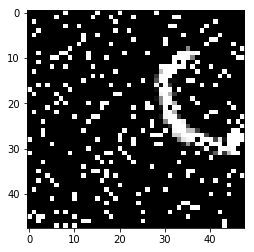

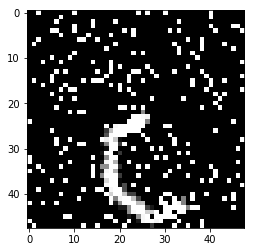

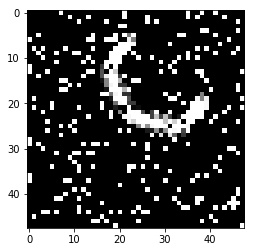

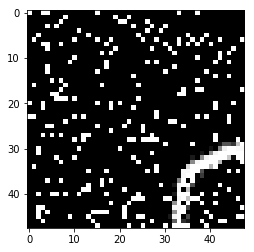

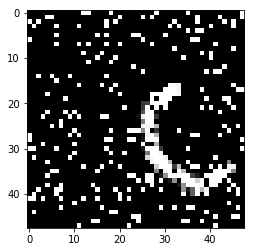

In [15]:
# See if transform_glyph works as intended
# a) Rotation between x degrees counter-clockwise to clockwise
# b) Shift within +/- y pixels all directions
# c) Noise @ z%
# Depending on file progress, [x,y,z] will differ

# Make 5 test images of first glyph
for i in range(0,5):
    newGlyph = transform_glyph(glyphs[0])
    imgPlot = plt.imshow(newGlyph, cmap="gray")
    plt.show()